In [176]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
warnings.filterwarnings("ignore")


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf


In [177]:
##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES

fp_data_base = dir_data.joinpath("iran_inputs_20241031.csv")


##  SETUP SOME SISEPUEDE STUFF

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

In [178]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

###   Review fields that are different

In [179]:
[
    x for x in df_inputs_example.columns if x not in df_inputs_raw.columns
]

['region',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_water',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_water',
 'strategy_id',
 'cost_enfu_fuel_ammonia_usd_per_tonne',
 'ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia',
 'ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia',
 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia',
 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia',
 'exports_enfu_pj_fuel_ammonia',
 'frac_enfu_fuel_demand_imported_pj_fuel_ammonia',
 'nemomod_entc_capital_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_capital_cost_fp_hydrogen_reformation_ccs_mm_usd_per_gw',
 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_tonne_co2_per_tj',
 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2',
 'nemomod_entc_fixed_cost_fp_ammonia_production_mm_usd_per_gw',
 'nemomod_entc_fixed_cost_fp_hydrogen_refo

In [180]:
##  SOME MANUAL FIXES FOR THE MOMENT

df_inputs_example["exports_enfu_pj_fuel_ammonia"] = 0


###   Build the file here

- Drop unecessary fields
- Use systematic keys/index fields
- add region name

In [181]:
fields_drop_example = [
    x for x in [regions.key, matt.dim_strategy_id]
    if x in df_inputs_example
]

fields_drop_raw = [
    x for x in ["iso_code3", "Year"]
    if x in df_inputs_example
]

df_inputs = sf.match_df_to_target_df(
    df_inputs_example
    .drop(
        columns = fields_drop_example,
    ),
    df_inputs_raw
    .drop(
        columns = fields_drop_raw,
    ),
    [time_periods.field_time_period],
    overwrite_only = False,
)

df_inputs[regions.key] = "iran"

# Make any data modifications

In [182]:
df_energy_share = (
    pd.read_csv(
        dir_data
        .joinpath("International Energy Agency - Electricity generation sources, Iran, 2022.csv")
    )
    .rename(
        columns = {
            "Electricity generation sources, Iran, 2022": "Fuel"
        }
    )
)
df_energy_share["Value"] = df_energy_share["Value"]/df_energy_share["Value"].sum()
df_energy_share

,Fuel,Value,Year,Units
0,Coal,0.001934,2022,GWh
1,Oil,0.135406,2022,GWh
2,Natural gas,0.802081,2022,GWh
3,Biofuels,0.000063,2022,GWh
4,Nuclear,0.021987,2022,GWh
5,Hydro,0.034322,2022,GWh
6,Solar PV,0.001999,2022,GWh
7,Wind,0.002209,2022,GWh


In [187]:
# dictionary mapping IEA to 
# NOTE (there are better ways to do this in the new SISEPUEDE data pipeline ecosystem using IEA classes, but this works for now)
dict_iea_to_ssp = dict(
    (
        x[1]["Fuel"], 
        x[1]["Fuel"]
        .lower()
        .replace(" ", "_")
    )
    for x in df_energy_share.iterrows()
)

dict_iea_to_ssp = dict(
    (
        k, 
        v
        .replace("biofuels", "biogas")
        .replace("solar_pv", "solar")
        .replace("hydro", "hydropower")
        .replace("natural_gas", "gas")
    ) 
    for k, v in dict_iea_to_ssp.items()
)

# drop biogas for now:
# - it's very small, 
# - we need to know what biofuels are important
# - it creates a conflict with the other sectors
dict_iea_to_ssp = dict(
    (k, f"pp_{v}") for k, v in dict_iea_to_ssp.items()
    if v not in ["biogas"]
)
dict_iea_to_ssp


{'Coal': 'pp_coal',
 'Oil': 'pp_oil',
 'Natural gas': 'pp_gas',
 'Nuclear': 'pp_nuclear',
 'Hydro': 'pp_hydropower',
 'Solar PV': 'pp_solar',
 'Wind': 'pp_wind'}

In [188]:
# get the MSP and map categories to fields
modvar = matt.get_variable("NemoMod MinShareProduction")

dict_cat_to_field = matt.get_category_replacement_field_dict(modvar)
cats_pp = [x for x in dict_cat_to_field.keys() if x.startswith("pp_")]

# build a dictionary of new msp fractions
dict_vals_new = dict((dict_cat_to_field.get(x), 0) for x in cats_pp)

for i, row in df_energy_share.iterrows():
    fuel = str(row["Fuel"])
    share = float(row["Value"])

    # assign to SSP field
    tech = dict_iea_to_ssp.get(fuel)
    field = dict_cat_to_field.get(tech)
    dict_vals_new.update({field: share})
    
# for now, we're going to be lazy and use the 2022 production numbers for all years
for k, v in dict_vals_new.items():
    df_inputs[k] = v


#  Let's try building transformations using this


In [192]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs,
)


##  Instantiate some transformations CAREFUL NOT TO OVERWRITE EXISTING TRANSFORMATIONS!!

In [157]:
# set an ouput path and instantiate 
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--
- go to `dir_transformers` and edit config files and `strategy_definitions.csv`
- then, go to next cell

In [195]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table




In [196]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")



Strategies defined at /Users/usuario/git/sisepuede_region_nbs/iran/transformations initialized in 1.85 seconds


In [163]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:CONSTRAINED,Constrained Climate Action,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0
70,6004,PFLO:TECHNOLOGICAL_ADOPTION,Technology Adoption Scenario,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [197]:
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups, 
    include_simplex_group_as_trajgroup = True,
    strategies = [0, 6003, 6004, 6005],
)



0

In [ ]:
#s0 = strategies.get_strategy(0)
#s0()["nemomod_entc_frac_min_share_production_pp_biogas"]

# Finally, load SISEPUEDE so that we can run it

In [210]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = ["iran"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-11-01 01:22:01,964 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-01 01:22:01,964 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-01 01:22:01,964 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-01 01:22:01,964 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-01 01:22:01,966 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-01 01:22:01,966 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-01 01:22:01,966 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-01 01:22:01,966 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-01 01:22

In [211]:
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [0, 6003, 6004, 6005],
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2024-11-01 01:22:47,487 - INFO - 
***	STARTING REGION iran	***

2024-11-01 01:22:47,487 - INFO - 
***	STARTING REGION iran	***

2024-11-01 01:22:47,487 - INFO - 
***	STARTING REGION iran	***

2024-11-01 01:22:47,487 - INFO - 
***	STARTING REGION iran	***

2024-11-01 01:22:48,984 - INFO - Trying run primary_id = 0 in region iran
2024-11-01 01:22:48,984 - INFO - Trying run primary_id = 0 in region iran
2024-11-01 01:22:48,984 - INFO - Trying run primary_id = 0 in region iran
2024-11-01 01:22:48,984 - INFO - Trying run primary_id = 0 in region iran
2024-11-01 01:22:48,985 - INFO - Running AFOLU model
2024-11-01 01:22:48,985 - INFO - Running AFOLU model
2024-11-01 01:22:48,985 - INFO - Running AFOLU model
2024-11-01 01:22:48,985 - INFO - Running AFOLU model
2024-11-01 01:22:49,071 - INFO - AFOLU model run successfully completed
2024-11-01 01:22:49,071 - INFO - AFOLU model run successfully completed
2024-11-01 01:22:49,071 - INFO - AFOLU model run successfully completed
2024-11-01 01:22:49,

2024-01-Nov 01:22:49.206 Opened SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-01-Nov 01:22:49.214 Added NEMO structure to SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-01-Nov 01:22:49.742 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-01 01:23:17,939 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:17,939 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:17,939 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:17,939 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:17,950 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:17,950 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:17,950 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:17,950 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:17,951 - INFO - Running Energy (Fugitive Emissions)
2024-11-01 01:23:17,951 - 

2024-01-Nov 01:23:17.852 Finished modeling scenario.


2024-11-01 01:23:18,095 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:18,095 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:18,095 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:18,095 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:18,096 - INFO - Running CircularEconomy model
2024-11-01 01:23:18,096 - INFO - Running CircularEconomy model
2024-11-01 01:23:18,096 - INFO - Running CircularEconomy model
2024-11-01 01:23:18,096 - INFO - Running CircularEconomy model
2024-11-01 01:23:18,121 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:18,121 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:18,121 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:18,121 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:18,122 - INFO - Running IPPU model
2024-11-01 01:23:18,122 - INFO - Running IPPU model
2024-11-01 01:23:18,122 - IN

2024-01-Nov 01:23:18.850 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-01 01:23:50,521 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:50,521 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:50,521 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:50,521 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:23:50,530 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:50,530 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:50,530 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:50,530 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:23:50,531 - INFO - Running Energy (Fugitive Emissions)
2024-11-01 01:23:50,531 - 

2024-01-Nov 01:23:50.402 Finished modeling scenario.


2024-11-01 01:23:50,678 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:50,678 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:50,678 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:50,678 - INFO - AFOLU model run successfully completed
2024-11-01 01:23:50,679 - INFO - Running CircularEconomy model
2024-11-01 01:23:50,679 - INFO - Running CircularEconomy model
2024-11-01 01:23:50,679 - INFO - Running CircularEconomy model
2024-11-01 01:23:50,679 - INFO - Running CircularEconomy model
2024-11-01 01:23:50,706 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:50,706 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:50,706 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:50,706 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:23:50,707 - INFO - Running IPPU model
2024-11-01 01:23:50,707 - INFO - Running IPPU model
2024-11-01 01:23:50,707 - IN

2024-01-Nov 01:23:51.797 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-01 01:24:25,073 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:25,073 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:25,073 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:25,073 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:25,082 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:25,082 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:25,082 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:25,082 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:25,082 - INFO - Running Energy (Fugitive Emissions)
2024-11-01 01:24:25,082 - 

2024-01-Nov 01:24:24.988 Finished modeling scenario.


2024-11-01 01:24:25,220 - INFO - AFOLU model run successfully completed
2024-11-01 01:24:25,220 - INFO - AFOLU model run successfully completed
2024-11-01 01:24:25,220 - INFO - AFOLU model run successfully completed
2024-11-01 01:24:25,220 - INFO - AFOLU model run successfully completed
2024-11-01 01:24:25,221 - INFO - Running CircularEconomy model
2024-11-01 01:24:25,221 - INFO - Running CircularEconomy model
2024-11-01 01:24:25,221 - INFO - Running CircularEconomy model
2024-11-01 01:24:25,221 - INFO - Running CircularEconomy model
2024-11-01 01:24:25,250 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:24:25,250 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:24:25,250 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:24:25,250 - INFO - CircularEconomy model run successfully completed
2024-11-01 01:24:25,251 - INFO - Running IPPU model
2024-11-01 01:24:25,251 - INFO - Running IPPU model
2024-11-01 01:24:25,251 - IN

2024-01-Nov 01:24:25.933 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-01 01:24:55,742 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:55,742 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:55,742 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:55,742 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-01 01:24:55,749 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:55,749 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:55,749 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:55,749 - INFO - EnergyProduction model run successfully completed
2024-11-01 01:24:55,750 - INFO - Running Energy (Fugitive Emissions)
2024-11-01 01:24:55,750 - 

2024-01-Nov 01:24:55.665 Finished modeling scenario.


2024-11-01 01:24:55,867 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-01T01;22;01.603947/sisepuede_run_2024-11-01T01;22;01.603947_output_database/ATTRIBUTE_PRIMARY.csv.
2024-11-01 01:24:55,867 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-01T01;22;01.603947/sisepuede_run_2024-11-01T01;22;01.603947_output_database/ATTRIBUTE_PRIMARY.csv.
2024-11-01 01:24:55,867 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-01T01;22;01.603947/sisepuede_run_2024-11-01T01;22;01.603947_output_database/ATTRIBUTE_PRIMARY.csv.
2024-11-01 01:24:55,867 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/s

{'iran': [0, 69069, 70070, 71071]}

In [173]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [228]:
df_output = ssp.read_output(None)

In [243]:
df_output[ssp.key_primary].unique()

array([    0, 69069, 70070, 71071])

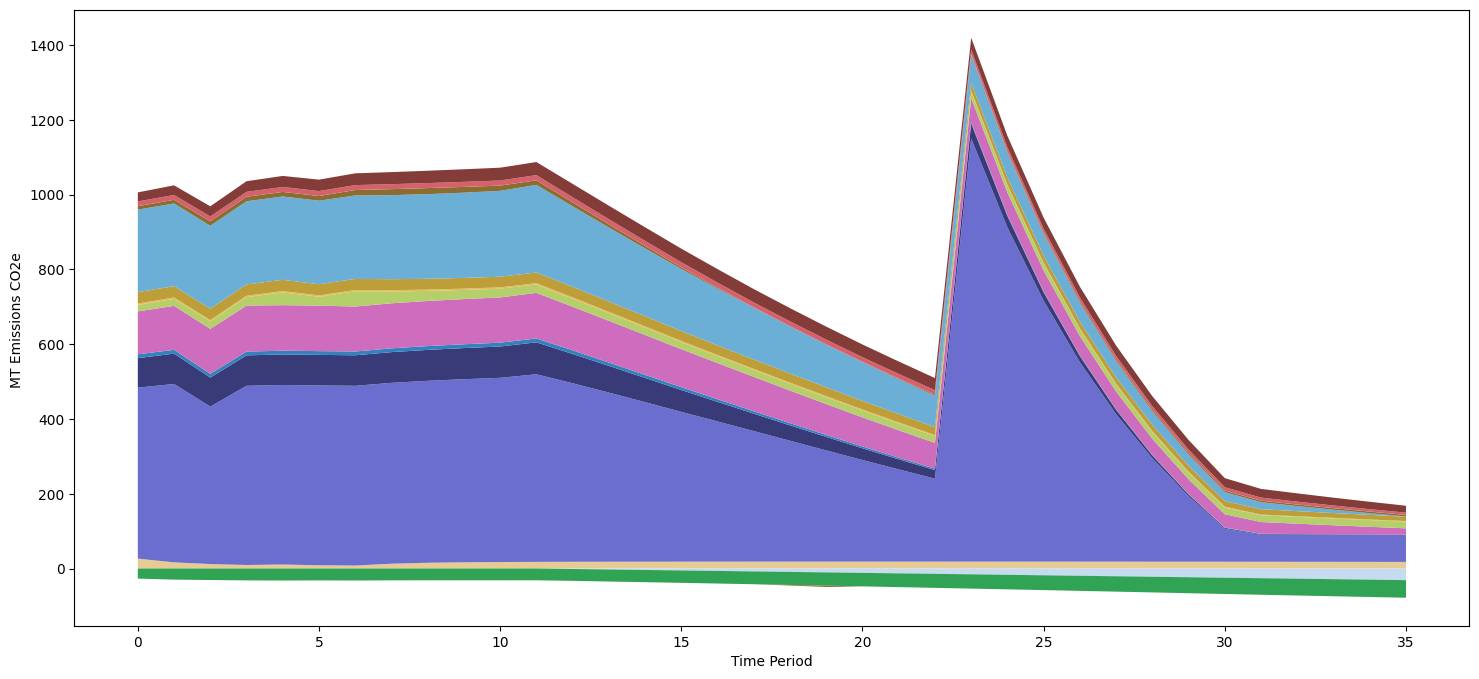

In [248]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_output[
    df_output[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)



# Export Wide File

In [258]:
df_out = ssp.read_output(None)
#df_in = ssp.read_input(None)

all_primaries = sorted(list(df_out[ssp.key_primary].unique()))
df_in = []
 
for region in ssp.regions:
    for primary in all_primaries: 
        df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
        df_in.append(df_in_filt.get(region))

df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)

df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [261]:
ssp.file_struct.dir_out

'/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out'